# Quick Start with AAanalysis
Dive into the powerful capabilities of ``AAanalysis``—a Python framework dedicated to sequence-based, alignment-free protein prediction. In this tutorial, using gamma-secretase substrates and non-substrates as an example, we'll focus on extracting interpretable features from protein sequences using the ``AAclust`` and ``CPP`` models and how they can be harnessed for binary classification tasks.

## What You Will Learn:

- ``Loading Sequences and Scales``: How to easily load protein sequences and their amino acid scales.
- ``Feature Engineering``: Extract essential features using the ``AAclust`` and ``CPP`` models.
- ``Protein Prediction``: Make predictions using the RandomForest model.
- ``Explainable AI``: Interpret predictions at the group and individual levels by combining ``CPP`` with ``SHAP``.

## 1. Loading Sequences and Scales
With AAanalysis, you have access to numerous benchmark datasets for protein sequence analysis. Using our γ-secretase substrates and non-substrates dataset as a hands-on example, you can effortlessly retrieve these datasets using the ``aa.load_dataset()`` function. Furthermore, amino acid scales, predominantly from AAindex, along with their hierarchical classification (known as ``AAontology``), are available at your fingertips with the ``aa.load_scales()`` function.

In [14]:
import aaanalysis as aa
# Load scales and scale categories (AAontology) 
df_scales = aa.load_scales()
# Load training data
df_seq = aa.load_dataset(name="DOM_GSEC", n=50)
df_seq.head(5)

,entry,sequence,label,tmd_start,tmd_stop,jmd_n,tmd,jmd_c
0,Q14802,MQKVTLGLLVFLAGFPVLDANDLEDKNSPFYYDWHSLQVGGLICAG...,0,37,59,NSPFYYDWHS,LQVGGLICAGVLCAMGIIIVMSA,KCKCKFGQKS
1,Q86UE4,MAARSWQDELAQQAEEGSARLREMLSVGLGFLRTELGLDLGLEPKR...,0,50,72,LGLEPKRYPG,WVILVGTGALGLLLLFLLGYGWA,AACAGARKKR
2,Q969W9,MHRLMGVNSTAAAAAGQPNVSCTCNCKRSLFQSMEITELEFVQIII...,0,41,63,FQSMEITELE,FVQIIIIVVVMMVMVVVITCLLS,HYKLSARSFI
3,P53801,MAPGVARGPTPYWRLRLGGAALLLLLIPVAAAQEPPGAACSQNTNK...,0,97,119,RWGVCWVNFE,ALIITMSVVGGTLLLGIAICCCC,CCRRKRSRKP
4,Q8IUW5,MAPRALPGSAVLAAAVFVGGAVSSPLVAPDNGSSRTLHSRTETTPS...,0,59,81,NDTGNGHPEY,IAYALVPVFFIMGLFGVLICHLL,KKKGYRCTTE


## 2.  Feature Engineering
The centerpiece of AAanalysis is the Comparative Physicochemical Profiling (``CPP``) model, which is supported by ``AAclust`` for the pre-selection of amino acid scales. 

### AAclust
Since redundancy is an essential problem for machine learning tasks, the ``AAclust`` object provides a lightweight wrapper for sklearn clustering algorithms such as Agglomerative clustering. AAclust clusters a set of scales and selects for each cluster the most representative scale (i.e., the scale closes to the cluster center). We will use AAclust to obtain a set of 100 scales, as defined by the ``n_clusters`` parameters:

In [31]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np
aac = aa.AAclust(model=AgglomerativeClustering, model_kwargs=dict(linkage="ward"))
X = np.array(df_scales)
scales = aac.fit(X, n_clusters=100, names=list(df_scales)) 
df_scales = df_scales[scales]
df_scales

,ANDN920101,SIMZ760101,NAKH900106,AURR980112,CORJ870107,ROBB760113,MIYS990104,BIGC670101,ROSG850102,ZIMJ680105,...,YUTK870102,SUEM840102,VASM830102,VELV850101,VENT840101,MONM990101,GEOR030102,GEOR030106,KARS160120,LINS030117
AA,,,,,,,,,,,,,,,,,,,,,
A,0.494,0.268,0.237,0.787,0.446,0.101,0.479,0.164,0.564,0.444,...,0.557,0.103,0.617,0.295,0,0.077,0.250,0.516,0.952,0.186
C,0.864,0.258,0.303,0.104,0.725,0.849,0.000,0.323,1.000,0.000,...,0.680,0.337,0.734,0.657,0,0.154,0.246,0.000,0.952,0.000
D,1.000,0.206,0.000,0.451,0.000,0.790,0.803,0.324,0.256,0.000,...,0.574,0.909,0.225,1.000,0,0.923,0.091,0.404,0.952,0.186
E,0.420,0.210,0.090,0.823,0.233,0.092,0.859,0.488,0.256,0.025,...,0.402,0.077,0.531,0.046,0,0.923,0.404,0.610,0.952,0.349
F,0.877,0.887,0.724,0.402,0.950,0.328,0.000,0.783,0.923,1.000,...,0.680,0.233,0.023,0.749,1,0.000,0.536,0.712,0.952,0.326
G,0.025,0.032,0.259,0.055,0.352,1.000,0.662,0.000,0.513,0.175,...,0.525,0.000,0.455,0.040,0,0.692,0.000,0.210,0.952,0.023
H,0.840,0.387,0.401,0.463,0.610,0.454,0.479,0.561,0.667,0.338,...,0.754,0.000,0.345,0.191,0,0.923,0.201,0.612,0.562,0.419
I,0.000,0.990,0.697,0.512,0.969,0.151,0.056,0.663,0.923,0.894,...,0.820,0.714,0.070,0.000,1,0.154,0.161,0.457,0.583,0.140
K,0.506,0.516,0.127,0.591,0.027,0.613,1.000,0.694,0.000,0.044,...,0.615,0.012,0.688,0.294,0,0.923,0.195,0.536,0.912,1.000


### Comparative Physicochemical Profiling (CPP)
 CPP is a sequence-based feature engineering algorithm. It aims at identifying a set of features most discriminant between two sets of sequences: the test set and the reference set. Supported by the ``SequenceFeature`` object (``sf``), A CPP feature integrates:
- ``Parts``: Are combination of a target middle domain (TMD) and N- and C-terminal adjacent regions (JMD-N and JMD-C, respectively), obtained ``sf.get_df_parts``.
- ``Splits``: These `Parts` can be split into various continuous segments or discontinuous patterns, specified ``sf.get_split_kws()``. 
- ``Scales``: Sets of amino acid scales.
We first use SequenceFeature to obtain Parts and Splits:

In [32]:
# Feature Engineering
y = list(df_seq["label"])
sf = aa.SequenceFeature()
df_parts = sf.get_df_parts(df_seq=df_seq, jmd_n_len=10, jmd_c_len=10, list_parts=["tmd_jmd"])
split_kws = sf.get_split_kws(n_split_max=1, split_types=["Segment"])
df_parts.head(5)

,tmd_jmd
D3ZZK3,RIIGDGANSTVLLVSVSGSVVLVVILIAAFVISRRRSKYSQAK
O14786,PGNVLKTLDPILITIIAMSALGVLLGAVCGVVLYCACWHNGMS
O35516,SELESPRNAQLLYLLAVAVVIILFFILLGVIMAKRKRKHGFLW
O43914,DCSCSTVSPGVLAGIVMGDLVLTVLIALAVYFLGRLVPRGRGA
O75581,YPTEEPAPQATNTVGSVIGVIVTIFVSGTVYFICQRMLCPRMK


Running the CPP algorithm creates all `Part`, `Split`, `Split` combinations and filters a selected maximum of non-redundant features. As a baseline approach,
we use CPP to compute the average values for the 100 selected scales over the entire TMD-JMD sequences:

In [33]:
# Small set of features (100 features created)
cpp = aa.CPP(df_parts=df_parts, df_scales=df_scales, split_kws=split_kws, verbose=False)
df_feat = cpp.run(labels=y, tmd_len=20, jmd_n_len=10, jmd_c_len=10, n_filter=100)  # Default values for lengths are used
df_feat

,feature,category,subcategory,scale_name,scale_description,abs_auc,abs_mean_dif,mean_dif,std_test,std_ref,p_val_mann_whitney,p_val_fdr_bh,positions
0,"TMD_JMD-Segment(1,1)-ANDN920101",Structure-Activity,Backbone-dynamics (-CH),α-CH chemical shifts (backbone-dynamics),"alpha-CH chemical shifts (Andersen et al., 1992)",0.130,0.022966,0.022966,0.054433,0.053266,0.025737,0.099022,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1..."
1,"TMD_JMD-Segment(1,1)-VASM830101",Conformation,Unclassified (Conformation),α-helix,Relative population of conformational state A ...,0.120,0.019298,-0.019298,0.046755,0.049127,0.039609,0.099022,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1..."
2,"TMD_JMD-Segment(1,1)-ROBB760113",Conformation,β-turn,β-turn,"Information measure for loop (Robson-Suzuki, 1...",0.108,0.021958,0.021958,0.060658,0.053190,0.062212,0.100670,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1..."
3,"TMD_JMD-Segment(1,1)-RACS820103",Conformation,Unclassified (Conformation),α-helix (left-handed),Average relative fractional occurrence in AL(i...,0.080,0.019579,-0.019579,0.072260,0.047452,0.166907,0.166907,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1..."


## 3. Protein Prediction
A feature matrix from a given set of CPP features can be created using ``sf.feat_matrix`` and used for machine learning:

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
X = sf.feat_matrix(df_parts=df_parts, df_scales=df_scales, features=df_feat["feature"])
# ML evaluation
rf = RandomForestClassifier()
cv_base = cross_val_score(rf, X, y, scoring="accuracy", cv=5, n_jobs=8) # Set n_jobs=1 to disable multi-processing
print(f"Mean accuracy of {round(np.mean(cv_base), 2)}")

Mean accuracy of 0.57


Creating more features with CPP will take some more time. but improve prediction performance: 

In [35]:
# Default CPP features  (around 100.000 features)
split_kws = sf.get_split_kws()
df_parts = sf.get_df_parts(df_seq=df_seq, jmd_n_len=10, jmd_c_len=10)
cpp = aa.CPP(df_parts=df_parts, df_scales=df_scales, split_kws=split_kws, verbose=False)
df_feat = cpp.run(labels=y, n_processes=8, n_filter=100)
df_feat

,feature,category,subcategory,scale_name,scale_description,abs_auc,abs_mean_dif,mean_dif,std_test,std_ref,p_val_mann_whitney,p_val_fdr_bh,positions
0,"TMD_C_JMD_C-Segment(2,3)-QIAN880106",Conformation,α-helix,α-helix (middle),Weights for alpha-helix at the window position...,0.387,0.121446,0.121446,0.069196,0.085013,0.000000e+00,0.000000e+00,"27,28,29,30,31,32,33"
1,"TMD_C_JMD_C-Segment(4,5)-ZIMJ680104",Energy,Isoelectric point,Isoelectric point,"Isoelectric point (Zimmerman et al., 1968)",0.373,0.220000,0.220000,0.123716,0.137350,1.000000e-10,2.475000e-07,"33,34,35,36"
2,"TMD_C_JMD_C-Pattern(N,5,8,12,15)-QIAN880106",Conformation,α-helix,α-helix (middle),Weights for alpha-helix at the window position...,0.358,0.144860,0.144860,0.079321,0.117515,7.000000e-10,7.150000e-07,"25,28,32,35"
3,"TMD_C_JMD_C-Segment(5,7)-LINS030101",ASA/Volume,Volume,Accessible surface area (ASA),Total accessible surfaces of whole residues (b...,0.354,0.237161,0.237161,0.145884,0.164285,1.100000e-09,7.150000e-07,"32,33,34"
4,"TMD_C_JMD_C-Segment(6,9)-ZIMJ680104",Energy,Isoelectric point,Isoelectric point,"Isoelectric point (Zimmerman et al., 1968)",0.341,0.263651,0.263651,0.187136,0.171995,4.000000e-09,1.185395e-06,"32,33"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,"JMD_N_TMD_N-Pattern(C,6,9)-NAKH900106",Composition,Mitochondrial proteins,Mitochondrial proteins,Normalized composition from animal (Nakashima ...,0.228,0.172120,-0.172120,0.180254,0.199987,8.754340e-05,2.693037e-04,"12,15"
96,"JMD_N_TMD_N-Pattern(C,6,9,12)-ZIMJ680105",Others,PC 2,Principal Component 1 (Zimmerman),"RF rank (Zimmerman et al., 1968)",0.227,0.133867,-0.133867,0.160532,0.161415,9.118090e-05,2.778863e-04,"9,12,15"
97,"JMD_N_TMD_N-Segment(7,8)-KARS160107",Shape,Side chain length,Eccentricity (maximum),Diameter (maximum eccentricity) (Karkbara-Knis...,0.227,0.098674,-0.098674,0.104428,0.124875,8.945330e-05,2.740061e-04,"16,17"
98,"JMD_N_TMD_N-Pattern(C,6,9,12)-SIMZ760101",Polarity,Hydrophobicity,Transfer free energy (TFE) to outside,"Transfer free energy (Simon, 1976), Cited by C...",0.225,0.161307,-0.161307,0.192235,0.212741,1.036749e-04,3.042894e-04,"9,12,15"


Which can be again used for machine learning:

Mean accuracy of 0.95


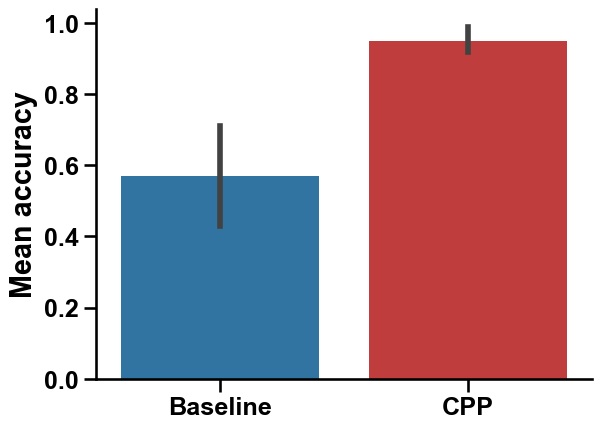

In [36]:
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import pandas as pd
X = sf.feat_matrix(df_parts=df_parts, df_scales=df_scales, features=df_feat["feature"])
# ML evaluation
rf = RandomForestClassifier()
cv = cross_val_score(rf, X, y, scoring="accuracy", cv=5, n_jobs=1) 
print(f"Mean accuracy of {round(np.mean(cv), 2)}")
aa.plot_settings(font_scale=1.1)
sns.barplot(pd.DataFrame({"Baseline": cv_base, "CPP": cv}), palette=["tab:blue", "tab:red"])
plt.ylabel("Mean accuracy", size=aa.plot_gcfs()+1)
sns.despine()
plt.show()

## 4. Explainable AI

### Explainable AI on group level

### Explainable AI on individual level